# Sunsets

In [28]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [9]:
"""for (unsigned i = 0; i < nangles; ++i) { 
        char filename[1024]; 
        sprintf(filename, "./skydome.%04d.ppm", i); 
        float angle = i / float(nangles - 1) * M_PI * 0.6; 
        fprintf(stderr, "Rendering image %d, angle = %0.2f\n", i, angle * 180 / M_PI); 
        renderSkydome(Vec3f(0, cos(angle), -sin(angle)), filename); 
    } """

for i in range(10):
    angle = i / 9 * math.pi * 0.6
    # vector is normalised direction from origin to the sun, looking down negative z axis
    print(f'angle = {angle * 180 / math.pi}, vector = {[0,math.cos(angle), -math.sin(angle)]}')

angle = 0.0, vector = [0, 1.0, -0.0]
angle = 12.0, vector = [0, 0.9781476007338057, -0.20791169081775931]
angle = 24.0, vector = [0, 0.9135454576426009, -0.40673664307580015]
angle = 35.99999999999999, vector = [0, 0.8090169943749475, -0.587785252292473]
angle = 48.0, vector = [0, 0.6691306063588583, -0.7431448254773941]
angle = 59.99999999999999, vector = [0, 0.5000000000000001, -0.8660254037844386]
angle = 71.99999999999999, vector = [0, 0.3090169943749477, -0.9510565162951535]
angle = 83.99999999999999, vector = [0, 0.10452846326765367, -0.9945218953682733]
angle = 96.0, vector = [0, -0.10452846326765333, -0.9945218953682734]
angle = 108.0, vector = [0, -0.30901699437494734, -0.9510565162951536]


In [ ]:


# ray_dir * t1 = point ray leaves atmosphere shell

In [116]:
def intersect_point_inside_sphere(so, rs, vo, vd):
    """
    Calculate the intersection point of a vector with a sphere, where the vector origin is inside the sphere.

    Parameters:
    so (np.array): The origin of the sphere.
    rs (float): The radius of the sphere.
    vo (np.array): The origin of the vector (inside the sphere).
    vd (np.array): The normalized direction of the vector.

    Returns:
    np.array: The point of intersection on the sphere, or None if there is no intersection.
    """
    # Vector from the origin of the vector to the origin of the sphere
    l = so - vo

    # Project l onto vd to find the distance from vo to the closest point on the vector to the center of the sphere
    t_ca = np.dot(l, vd)

    # The distance from the closest point on the vector to the sphere's center
    d = np.sqrt(np.dot(l, l) - t_ca**2)

    # If d is greater than the radius, there is no intersection
    if d > rs:
        return None

    # Distance from the closest point on the vector to the intersection point
    t_hc = np.sqrt(rs**2 - d**2)

    # Calculate the intersection point (taking the far intersection point as the vector is inside the sphere)
    t = t_ca + t_hc
    intersection = vo + t * vd

    return (intersection, t)

# Example usage for a vector inside the sphere
so = np.array([0, 0, 0])  # Sphere origin
rs = 5                    # Sphere radius
vo = np.array([1, 0, 0])  # Vector origin inside the sphere
vd = np.array([1, 0, 0])  # Vector direction (normalized)

intersect_point_inside_sphere(so, rs, vo, vd)

(array([5., 0., 0.]), 4.0)

95354.16388554685 2771295.337560875 0.0 1.0


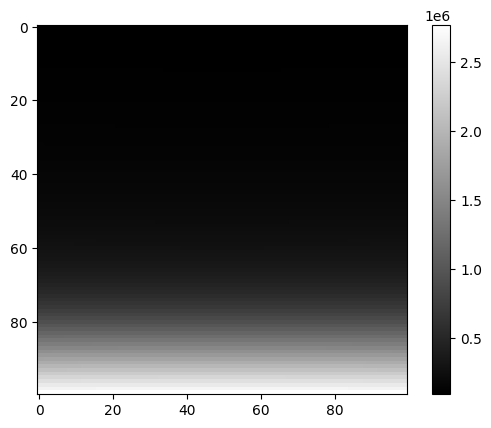

In [119]:
"""
First test:

given ray origin, and ray directions calculate the intersection distances of the containing sphere and plot these
"""

er = 6360e3 # Earth radius
ar = 6420e3 # Atmosphere radius
eo = np.array([0,0,0]) # Earth origin (centre)
camera_h = 1 # camera height off ground
camera_d = 5 # camera distance from image plane
image_s_x = 2 # x size of image plane
image_s_y = 5 # y size of image plane (image plane sits on the ground a y = er)
ro = np.array([0, er + camera_h, camera_d]) # ray origin (1m above the ground, 5m away from the canvas at 0)
res = 100 # resolution

img = np.zeros((res, res))

for x in range(img.shape[0]):
    for y in range(img.shape[1]):
        x_coord = ((x / (res - 1)) - 0.5) * (image_s_x / 2)
        y_coord = (1 - (y / (res - 1))) * image_s_y
        
        rd = np.array([x_coord, y_coord + er, 0]) - ro
        rd = rd / np.linalg.norm(rd)

        a_i, t = intersect_point_inside_sphere(eo, ar, ro, rd)
        
        img[x,y] = t

img_norm = (img - img.min()) / (img.max() - img.min())
print(img.min(), img.max(), img_norm.min(), img_norm.max())

plt.imshow(img.transpose(), cmap = 'gray')
plt.colorbar()

In [120]:
print(ro)

[0.000000e+00 6.360001e+06 5.000000e+00]


In [ ]:
# raleigh scattering constants for rgb channels
beta_r = np.array([3.8e-6, 13.5e-6, 33.1e-6])
# mie scattering constant, used for all channels
beta_m = 21e-6

def raleigh_phase(mu):
    return 3.0 / (16.0 * math.pi) * (1 + mu * mu)

def mie_phase(mu, g):
    num = (1-g**2)*(1+mu**2)
    denom = (2+g**2)*(1+g**2-2*g*mu)**1.5
    return (3/8)*math.pi * (num/denom)

eo = np.array([0,0,0]) # Earth origin (centre)
er = 6360e3 # Earth radius
ar = 6420e3 # Atmosphere radius

#sun_dir = np.array([0,0,-1])
#ro = np.array([0.000000e+00, 6.360001e+06, 5.000000e+00])
#

In [177]:
def calculate_light(ro, rd, sun_dir):
    _, t = intersect_point_inside_sphere(eo, ar, ro, rd)
    
    n_samples = 16
    n_samples_light = 8
    seg_length = t / n_samples
    t_current = 0
    sum_r = np.array([0,0,0]) # rayleigh contribution
    sum_m = np.array([0,0,0]) # mie contribution
    optical_depth_r = 0
    optical_depth_m = 0
    mu = np.dot(rd, sun_dir) # both rd and sun_dir should be in same direction, I think?
    phase_r = raleigh_phase(mu) 
    g = 0.76
    phase_m = mie_phase(mu, g)
    
    scale_h_r = 7994 # Raleight scale height
    scale_h_m = 1200 # Mie scale height
    
    optical_depth_r = 0
    optical_depth_m = 0
    
    for i in range(n_samples):
        sample_pos = ro + (t_current + seg_length * 0.5) * rd
        height = np.linalg.norm(sample_pos) - er
        
        # optical depth for light
        # multiply by seg_length because we assume a constant depth (i.e. density)
        # along each segment
        hr = math.exp(-height / scale_h_r) * seg_length
        hm = math.exp(-height / scale_h_m) * seg_length
        optical_depth_r += hr
        optical_depth_m += hm
    
        # t1_light is the distance from our sample point in sun_dir direction
        # to the edge of the atmosphere
        _, t1_light = intersect_point_inside_sphere(eo, ar, sample_pos, sun_dir)
        seg_length_light = t1_light / n_samples_light
        t_current_light = 0
        optical_depth_light_r = 0
        optical_depth_light_m = 0
    
        light_outside_earth = True
        for j in range(n_samples_light):
            light_sample_pos = sample_pos + (t_current_light + seg_length_light * 0.5) * sun_dir
            height_light = np.linalg.norm(light_sample_pos) - er
            # less than zero means we are within the earth 
            if height_light < 0:
                light_outside_earth = False
                break
            
            optical_depth_light_r += math.exp(-height_light / scale_h_r) * seg_length_light
            optical_depth_light_m += math.exp(-height_light / scale_h_m) * seg_length_light
    
            t_current_light += seg_length_light
    
        if light_outside_earth:
            """
            # rayleigh
            x_to_camera_transmittance_r = np.exp(-beta_r * optical_depth_r)
            x_to_light_transmittance_r = np.exp(-beta_r * optical_depth_light_r)
            rayleigh_attenuation = x_to_camera_transmittance_r*x_to_light_transmittance_r
    
            # mie
            x_to_camera_transmittance_m = np.exp(-beta_m * 1.1 * optical_depth_m)
            x_to_light_transmittance_m = np.exp(-beta_m * 1.1 * optical_depth_light_m)
            mie_attenuation = x_to_camera_transmittance_m*x_to_light_transmittance_m
    
            attenuation = rayleigh_attenuation * mie_attenuation
    
            # hm and hr count as our density terms here
            sum_r = sum_r + attenuation * hr
            sum_m = sum_m + attenuation * hm
            """
            """
            Vec3f tau = betaR * (opticalDepthR + opticalDepthLightR) + betaM * 1.1f * (opticalDepthM + opticalDepthLightM); 
            Vec3f attenuation(exp(-tau.x), exp(-tau.y), exp(-tau.z)); 
            sumR += attenuation * hr; 
            sumM += attenuation * hm;
            """

            tau = beta_r * (optical_depth_r + optical_depth_light_r) + beta_m * 1.1 * (optical_depth_m + optical_depth_light_m)
            attenuation = np.exp(-tau)
            sum_r = sum_r + attenuation * hr
            sum_m = sum_m + attenuation * hm

        
    
        t_current += seg_length
    
    return (sum_r * beta_r * phase_r + sum_m * beta_m * phase_m) * 20; 

In [188]:
"""
Second test:

given ray origin, and ray directions calculate the intersection distances of the containing sphere and plot these
"""

camera_h = 1 # camera height off ground
camera_d = 50000 # camera distance from image plane
image_s_x = 10000 # x size of image plane
image_s_y = 20000 # y size of image plane (image plane sits on the ground a y = er)
ro = np.array([0, er + camera_h, camera_d]) # ray origin (1m above the ground, 5m away from the canvas at 0)
res = 100 # resolution

sun_dir = np.array([0,1,-1])
sun_dir = sun_dir / np.linalg.norm(sun_dir)

frames = 10
angle_step = (math.pi/2) / frames
img = np.zeros((frames, res, res, 3))

for angle_i in range(frames):
    print(f'frame {angle_i}')
    angle = angle_i * angle_step
    sun_dir = np.array([0, math.sin(angle), -math.cos(angle)])
        
    for x in range(res):
        for y in range(res):
            x_coord = ((x / (res - 1)) - 0.5) * (image_s_x / 2)
            y_coord = (1 - (y / (res - 1))) * image_s_y
            
            rd = np.array([x_coord, y_coord + er, 0]) - ro
            rd = rd / np.linalg.norm(rd)
    
            img[angle_i, y,x, :] = calculate_light(ro, rd, sun_dir)


#plt.imshow(img / img.max())


frame 0
frame 1
frame 2
frame 3
frame 4
frame 5
frame 6
frame 7
frame 8
frame 9


0.0003669617580211794

In [186]:
def plot_images(rows, cols, img, figsize=(20,10)):
    fig, axes = plt.subplots(rows, cols, figsize=(20,10))
    
    for r in range(rows):
        for c in range(cols):
            i = c + r * cols 
            img_slice = img[i,:,:,:]
            img_slice = img_slice / img_slice.max()
        
            # Display each slice
            ax = axes[r,c]
            im = ax.imshow(img_slice)
            ax.set_title(f"Image {i}")
            ax.axis('off')
    
    # Show the plot
    plt.show()

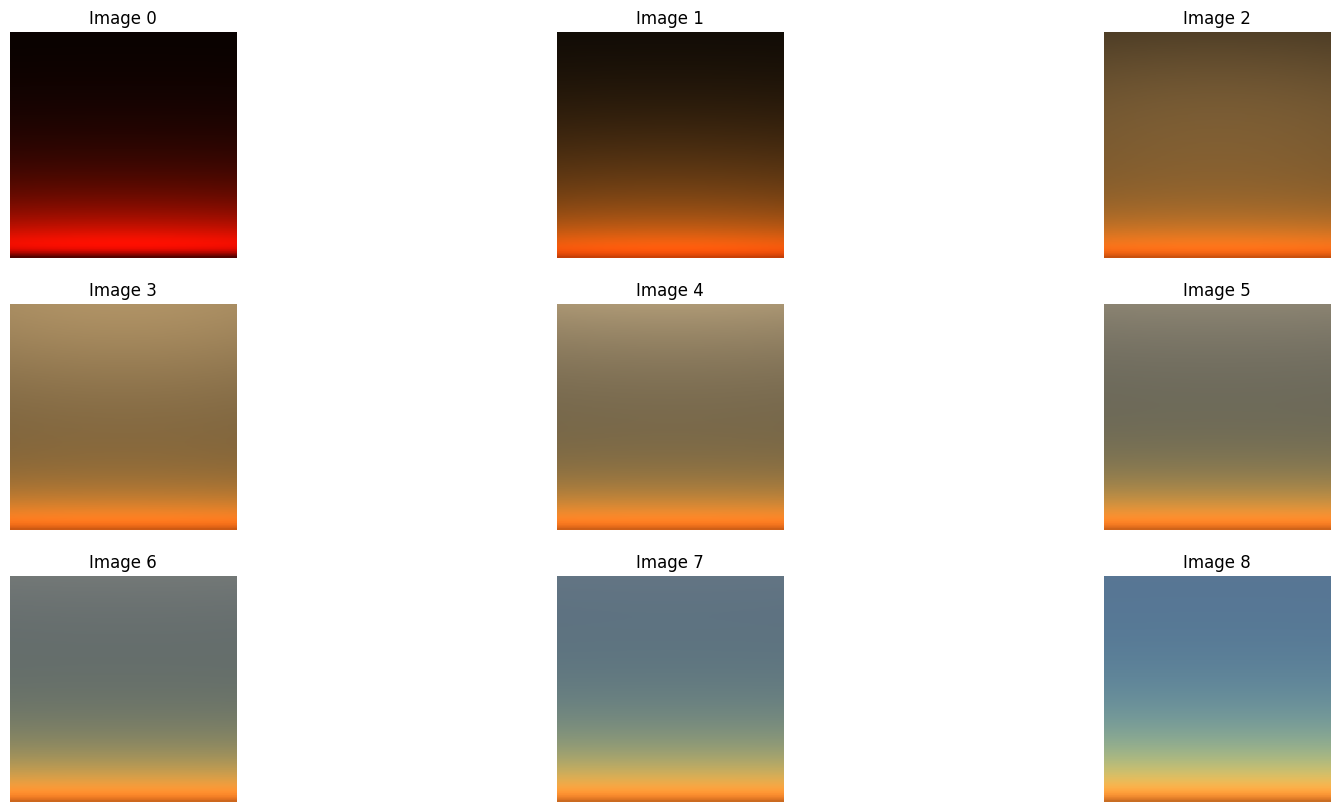

In [189]:
plot_images(3,3,img)

In [ ]:
# Render that skydome and see if it matches

